# Loss Landscapes of Activation Functions

## Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Defining Functions for LL

In [2]:
# Make the Plot

import matplotlib.pyplot as plt
#import numpy as np
#import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers


##########################################################################
class RandomCoordinates(object):
    def __init__(self, origin):
        self.origin_ = origin
        self.v0_ = normalize_weights(
            [np.random.normal(size=w.shape) for w in origin], origin
        )
        self.v1_ = normalize_weights(
            [np.random.normal(size=w.shape) for w in origin], origin
        )

    def __call__(self, a, b):
        return [
            a * w0 + b * w1 + wc
            for w0, w1, wc in zip(self.v0_, self.v1_, self.origin_)
        ]


def normalize_weights(weights, origin):
    return [
        w * np.linalg.norm(wc) / np.linalg.norm(w)
        for w, wc in zip(weights, origin)
    ]


##########################################################################
class LossSurface(object):
    def __init__(self, model, inputs, outputs):
        self.model_ = model
        self.inputs_ = inputs
        self.outputs_ = outputs

    def compile(self, range, points, coords):
        a_grid = tf.linspace(-1.0, 1.0, num=points) ** 3 * range
        b_grid = tf.linspace(-1.0, 1.0, num=points) ** 3 * range
        loss_grid = np.empty([len(a_grid), len(b_grid)])
        for i, a in enumerate(a_grid):
            for j, b in enumerate(b_grid):
                self.model_.set_weights(coords(a, b))
                loss = self.model_.test_on_batch(
                    self.inputs_, self.outputs_, return_dict=True
                )["loss"]
                loss_grid[j, i] = loss
        self.model_.set_weights(coords.origin_)
        self.a_grid_ = a_grid
        self.b_grid_ = b_grid
        self.loss_grid_ = loss_grid

    def plot(self, range=1.0, points=24, levels=20, ax=None, **kwargs):
        xs = self.a_grid_
        ys = self.b_grid_
        zs = self.loss_grid_
        if ax is None:
            _, ax = plt.subplots(**kwargs)
            ax.set_title("The Loss Surface")
            ax.set_aspect("equal")
        # Set Levels
        min_loss = zs.min()
        max_loss = zs.max()
        levels = tf.exp(
            tf.linspace(
                tf.math.log(min_loss), tf.math.log(max_loss), num=levels
            )
        )
        # Create Contour Plot
        CS = ax.contour(
            xs,
            ys,
            zs,
            levels=levels,
            cmap="magma",
            linewidths=0.75,
            norm=matplotlib.colors.LogNorm(vmin=min_loss, vmax=max_loss * 2.0),
        )
        ax.clabel(CS, inline=True, fontsize=8, fmt="%1.2f")
        return ax
    

In [3]:
##########################################################################    
from sklearn.decomposition import PCA

# Some utility functions to reshape network weights
def vectorize_weights_(weights):
    vec = [w.flatten() for w in weights]
    vec = np.hstack(vec)
    return vec

##########################################################################
def vectorize_weight_list_(weight_list):
    vec_list = []
    for weights in weight_list:
        vec_list.append(vectorize_weights_(weights))
    weight_matrix = np.column_stack(vec_list)
    return weight_matrix

##########################################################################
def shape_weight_matrix_like_(weight_matrix, example):
    weight_vecs = np.hsplit(weight_matrix, weight_matrix.shape[1])
    sizes = [v.size for v in example]
    shapes = [v.shape for v in example]
    weight_list = []
    for net_weights in weight_vecs:
        vs = np.split(net_weights, np.cumsum(sizes))[:-1]
        vs = [v.reshape(s) for v, s in zip(vs, shapes)]
        weight_list.append(vs)
    return weight_list

##########################################################################
def get_path_components_(training_path, n_components=2):
    # Vectorize network weights
    weight_matrix = vectorize_weight_list_(training_path)
    # Create components
    pca = PCA(n_components=2, whiten=True)
    components = pca.fit_transform(weight_matrix)
    # Reshape to fit network
    example = training_path[0]
    weight_list = shape_weight_matrix_like_(components, example)
    return pca, weight_list

##########################################################################
class PCACoordinates(object):
    def __init__(self, training_path):
        origin = training_path[-1]
        self.pca_, self.components = get_path_components_(training_path)
        self.set_origin(origin)

    def __call__(self, a, b):
        return [
            a * w0 + b * w1 + wc
            for w0, w1, wc in zip(self.v0_, self.v1_, self.origin_)
        ]

    def set_origin(self, origin, renorm=True):
        self.origin_ = origin
        if renorm:
            self.v0_ = normalize_weights(self.components[0], origin)
            self.v1_ = normalize_weights(self.components[1], origin)

        

In [4]:
def weights_to_coordinates(coords, training_path):
    """Project the training path onto the first two principal components
using the pseudoinverse."""
    components = [coords.v0_, coords.v1_]
    comp_matrix = vectorize_weight_list_(components)
    # the pseudoinverse
    comp_matrix_i = np.linalg.pinv(comp_matrix)
    # the origin vector
    w_c = vectorize_weights_(training_path[-1])
    # center the weights on the training path and project onto components
    coord_path = np.array(
        [
            comp_matrix_i @ (vectorize_weights_(weights) - w_c)
            for weights in training_path
        ]
    )
    return coord_path


def plot_training_path(coords, training_path, ax=None, end=None, **kwargs):
    path = weights_to_coordinates(coords, training_path)
    if ax is None:
        fig, ax = plt.subplots(**kwargs)
    colors = range(path.shape[0])
    end = path.shape[0] if end is None else end
    norm = plt.Normalize(0, end)
    ax.scatter(
        path[:, 0], path[:, 1], s=4, c=colors, cmap="cividis", norm=norm,
    )
    return ax

## Defining Activation Functions

## Loading Data

In [5]:

um_classes = 10
input_shape = (32, 32, 3)

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

print("x_train shape: {} - y_train shape: {}".format(X_train.shape,y_train.shape))
print("x_test shape: {} - y_test shape: {}".format(X_test.shape,y_test.shape))


x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [6]:

# Scale images to the [0, 1] range
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, um_classes)
y_test = keras.utils.to_categorical(y_test, um_classes)


In [7]:
# merge the original train and test data together

x_train=np.concatenate((X_train,X_test))
y_train=np.concatenate((y_train, y_test))
print("x_train shape: {} - y_train shape: {}".format(x_train.shape,y_train.shape))

x_train shape: (60000, 32, 32, 3) - y_train shape: (60000, 10)


In [8]:
from sklearn.model_selection import train_test_split

#split test and the remaining data
X_remain, X_test, y_remain, y_test= train_test_split(x_train,y_train,test_size=0.2)
print("x_test shape: {} - y_test shape: {}".format(X_test.shape,X_test.shape))

x_test shape: (12000, 32, 32, 3) - y_test shape: (12000, 32, 32, 3)


In [9]:

X_train, X_discard, y_train, y_discard= train_test_split(X_remain,y_remain,train_size=0.1)

In [10]:
## Making Basic Neural Network

In [17]:
# customized model
inputs = keras.Input(shape=(32, 32, 3))
x=layers.Conv2D(32, kernel_size=(3, 3))(inputs)
x=layers.BatchNormalization()(x)
x=layers.Activation("relu")(x)

#x=layers.Dropout(0.1)(x)

x=layers.MaxPooling2D(pool_size=(2, 2))(x)

x=layers.Conv2D(64, kernel_size=(3, 3))(x)
x=layers.BatchNormalization()(x)
x=layers.Activation("relu")(x)

#x=layers.Dropout(0.1)(x)

x=layers.MaxPooling2D(pool_size=(2, 2))(x)
x=layers.Flatten()(x)
outputs=layers.Dense(um_classes, activation="softmax")(x)

model=keras.Model(inputs,outputs)
model.compile(loss="categorical_crossentropy", optimizer="adam", 
                         metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        1849

## Running the Model

In [21]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
#history = model_customized.fit(X_train, y_train, epochs=50, batch_size=32, 
                               #callbacks=[callback], validation_split=0.2, verbose=1)

model.compile(
    optimizer="adam", loss="mse",
)

training_path = [model.get_weights()]
# Callback to collect weights as the model trains
collect_weights = callbacks.LambdaCallback(
    on_epoch_end=(
        lambda batch, logs: training_path.append(model.get_weights())
    )
)

history = model.fit(
    X_train, y_train,
    steps_per_epoch=1,
    epochs=40,
    callbacks=[collect_weights],
    verbose=1,
)

Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.1106
Epoch 2/40
1/1 [==============================] - 0s 224ms/step - loss: 0.1085
Epoch 3/40
1/1 [==============================] - 0s 301ms/step - loss: 0.1037
Epoch 4/40
1/1 [==============================] - 0s 262ms/step - loss: 0.1014
Epoch 5/40
1/1 [==============================] - 0s 281ms/step - loss: 0.0961
Epoch 6/40
1/1 [==============================] - 0s 250ms/step - loss: 0.0910
Epoch 7/40
1/1 [==============================] - 0s 265ms/step - loss: 0.0893
Epoch 8/40
1/1 [==============================] - 0s 250ms/step - loss: 0.0865
Epoch 9/40
1/1 [==============================] - 0s 262ms/step - loss: 0.0857
Epoch 10/40
1/1 [==============================] - 0s 236ms/step - loss: 0.0842
Epoch 11/40
1/1 [==============================] - 1s 717ms/step - loss: 0.0826
Epoch 12/40
1/1 [==============================] - 0s 213ms/step - loss: 0.0810
Epoch 13/40
1/1 [==============================] - 0

## Performance

In [22]:
temp={} # store the performance


score = model_customized.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test error:", 1-score[1])

temp["Customized Model Test error"]=1-score[1]

import pandas as pd

performance =pd.DataFrame([temp])



TypeError: 'float' object is not subscriptable

NameError: name 'matplotlib' is not defined

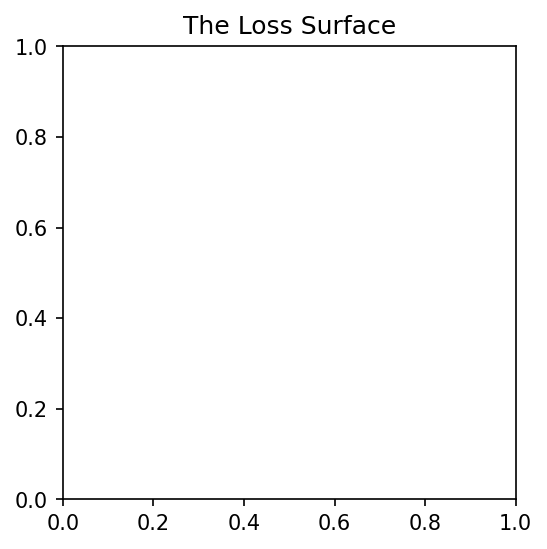

In [24]:
pcoords = PCACoordinates(training_path)
loss_surface = LossSurface(model, X_train, y_train)
loss_surface.compile(points=30, coords=pcoords, range=0.4)
ax = loss_surface.plot(dpi=150)
plot_training_path(pcoords, training_path, ax)